### Start a spark session

In [20]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.jars.packages", "io.delta:delta-sharing-spark_2.12:3.3.0") \
    .getOrCreate()

ConnectionRefusedError: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée

### List Tables
Use the provided config

In [ ]:
import delta_sharing
config = "config.share"
client = delta_sharing.SharingClient(config)
client.list_all_tables()

[Table(name='ev3_device_data', share='start_hack_2025', schema='start_hack_2025'),
 Table(name='cc_api_logs', share='start_hack_2025', schema='start_hack_2025'),
 Table(name='ev3_dataprofile', share='start_hack_2025', schema='start_hack_2025')]

### Table 1
Energyvalve 3 dataprofile describing the datapoints found in the device data table.

In [ ]:
import pandas as pd
df = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.ev3_dataprofile")

In [ ]:
df.columns

['id',
 'access',
 'basetype',
 'description',
 'format',
 'name',
 'privacy',
 'restriction',
 'definedBy',
 'unit']

### Table 2
Energyvalve 3 device data. **Big data** list of timeseries samples for devices. Devices are differentiated by the **device_id** column.

In [ ]:
df2 = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.ev3_device_data") # .limit(3)

In [ ]:
df2.columns

['device_id',
 'dataprofile_id',
 'cloud_received_time',
 'sample_time',
 'year',
 'year_month',
 'year_month_day',
 'influx_migration_source_filename',
 'T1_remote_K',
 'T2_embeded_K',
 'RelFlow_Fb_Rel2Vmax',
 'RelPower_Fb_Rel2Pmax',
 'AbsFlow_Fb_m3s',
 'AbsPower_Fb_W',
 'Heating_E_J',
 'Glycol_Concentration_Rel',
 'ControlMode_Write',
 'Cooling_E_J',
 'RelPos_Fb',
 'DeltaT_Limitation_Write',
 'SpDeltaT_K_Write',
 'Pmax_Rel_Write',
 'Vmax_Rel_Write',
 'InstallationPosition_Write',
 'Override_Write',
 'DN_Size',
 'SpFlow_DeltaT_lmin_Write',
 'DDC_Sp_Rel',
 'SpDeltaT_applied_K',
 'Error_Status_Cloud',
 'DDC_BUS_Sp_Write',
 'dT_Manager_Ste',
 'Active_dT_Manager_total_h',
 'DeltaT_K',
 'DDC_Sp_V',
 'OperatingHours',
 'Flow_Volume_total_m3',
 'Y3AnalogInputValue']

### Plot
Heat Exchanger Characteristic

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

device_id = "1a9da8fa-6fa8-49f3-8aaa-420b34eefe57"
df_data = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.ev3_device_data").filter((col("device_id") == device_id) & (col("year_month") == "202103")).toPandas()

<Axes: xlabel='sample_time', ylabel='year_month_day'>

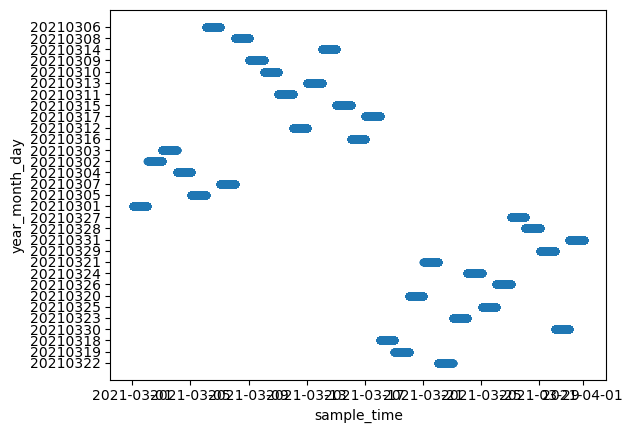

In [ ]:
df_data.plot(kind='scatter', x='sample_time', y='year_month_day')

### Table 3
Cloud api logs describing interactions with our cloud.

In [ ]:
df3 = spark.read.format("deltaSharing").load("config.share#start_hack_2025.start_hack_2025.cc_api_logs") #.limit(3)

In [ ]:
# quantiles = df3.approxQuantile("durationInMs", [0.25, 0.5, 0.75], 0.05) 
# quantiles

In [ ]:
# from pyspark.sql.functions import mean, stddev

# result_df = df3.groupBy("device_id").agg(
#     mean("durationInMs").alias("avg_duration"),
#     stddev("durationInMs").alias("std_duration")
# )

In [ ]:
df3.head(5)

[Row(api='device', class=None, cloudEnv='production', component='core-cloud', correlationId='CCB:9ae22714-7c8c-4490-8f07-d5fd7793b6cf', developmentDevice=None, durationInMs=119, host='logsearch-lifeline-agent-stateful-0.logsearch-lifeline-agent-stateful.default.svc.cluster.local', httpStatus=401, logEnv='production', method='POST', principal=None, requestId='a3818cc09b0af2d7c72134ca5fa93eda', requestURI='/device-api/registration', requestURL='https://connect.g2bcc.com/device-api/registration', signature=None, signatureFull=None, signatureId=None, threadName='http-nio-8080-exec-29', userAgent='sharedlogic/3.22.5-0 (bsp 10.8.0-0, model 1.2.1-0, bacnet 2.1.0)', timestamp=datetime.datetime(2025, 1, 16, 8, 45, 23, 365000)),
 Row(api='device', class='DeviceApiV2DeviceController', cloudEnv='production', component='core-cloud', correlationId='CCB:fc660e65-b629-4ca1-9adc-ac91cd3fb090', developmentDevice=None, durationInMs=24, host='logsearch-lifeline-agent-stateful-0.logsearch-lifeline-agent-st

In [ ]:
df3.columns

['api',
 'class',
 'cloudEnv',
 'component',
 'correlationId',
 'developmentDevice',
 'durationInMs',
 'host',
 'httpStatus',
 'logEnv',
 'method',
 'principal',
 'requestId',
 'requestURI',
 'requestURL',
 'signature',
 'signatureFull',
 'signatureId',
 'threadName',
 'userAgent',
 'timestamp']

In [ ]:
df2.where(col("device_id") == '492e77b5-61db-45d8-aedd-598132a44471').head(5)

[Row(device_id='492e77b5-61db-45d8-aedd-598132a44471', dataprofile_id='energyvalve3/1.11', cloud_received_time=None, sample_time=datetime.datetime(2020, 9, 30, 7, 10, 2, 391000), year='2020', year_month='202009', year_month_day='20200930', influx_migration_source_filename='2020-09-30_05.gz', T1_remote_K=None, T2_embeded_K=None, RelFlow_Fb_Rel2Vmax=None, RelPower_Fb_Rel2Pmax=None, AbsFlow_Fb_m3s=None, AbsPower_Fb_W=None, Heating_E_J=None, Glycol_Concentration_Rel=None, ControlMode_Write=None, Cooling_E_J=None, RelPos_Fb=None, DeltaT_Limitation_Write=None, SpDeltaT_K_Write=None, Pmax_Rel_Write=None, Vmax_Rel_Write=None, InstallationPosition_Write=None, Override_Write=None, DN_Size=None, SpFlow_DeltaT_lmin_Write=None, DDC_Sp_Rel=None, SpDeltaT_applied_K=None, Error_Status_Cloud=None, DDC_BUS_Sp_Write=None, dT_Manager_Ste=None, Active_dT_Manager_total_h=None, DeltaT_K=None, DDC_Sp_V=None, OperatingHours=None, Flow_Volume_total_m3=None, Y3AnalogInputValue=None),
 Row(device_id='492e77b5-61d

In [ ]:
df3.head(5)

[Row(api='device', class=None, cloudEnv='production', component='core-cloud', correlationId='CCB:9ae22714-7c8c-4490-8f07-d5fd7793b6cf', developmentDevice=None, durationInMs=119, host='logsearch-lifeline-agent-stateful-0.logsearch-lifeline-agent-stateful.default.svc.cluster.local', httpStatus=401, logEnv='production', method='POST', principal=None, requestId='a3818cc09b0af2d7c72134ca5fa93eda', requestURI='/device-api/registration', requestURL='https://connect.g2bcc.com/device-api/registration', signature=None, signatureFull=None, signatureId=None, threadName='http-nio-8080-exec-29', userAgent='sharedlogic/3.22.5-0 (bsp 10.8.0-0, model 1.2.1-0, bacnet 2.1.0)', timestamp=datetime.datetime(2025, 1, 16, 8, 45, 23, 365000)),
 Row(api='device', class='DeviceApiV2DeviceController', cloudEnv='production', component='core-cloud', correlationId='CCB:fc660e65-b629-4ca1-9adc-ac91cd3fb090', developmentDevice=None, durationInMs=24, host='logsearch-lifeline-agent-stateful-0.logsearch-lifeline-agent-st

In [ ]:
device_ids = [row.device_id for row in df2.select("device_id").distinct().limit(10).collect()]

In [ ]:

# Filter the main DataFrame to only include those devices
df3_filtered = df3.filter(col("principal").isin(device_ids))

In [ ]:
from pyspark.sql.functions import col, expr

# Define the quantiles you need (e.g., 25th, 50th (median), and 75th percentile)
quantiles = [0.25, 0.5, 0.75]

# Compute the quantiles per principal
df_quantiles = df3_filtered.groupBy("principal").agg(
    expr(f"percentile_approx(durationInMs, {quantiles[0]})").alias("Q1"),
    expr(f"percentile_approx(durationInMs, {quantiles[1]})").alias("Median"),
    expr(f"percentile_approx(durationInMs, {quantiles[2]})").alias("Q3")
)



Py4JJavaError: An error occurred while calling o102.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 614 in stage 72.0 failed 1 times, most recent failure: Lost task 614.0 in stage 72.0 (TID 2994) (localhost executor driver): org.apache.parquet.io.ParquetDecodingException: Failed to read dictionary
	at org.apache.parquet.hadoop.DictionaryPageReader.lambda$readDictionaryPage$0(DictionaryPageReader.java:105)
	at java.util.concurrent.ConcurrentHashMap.computeIfAbsent(ConcurrentHashMap.java:1660)
	at org.apache.parquet.hadoop.DictionaryPageReader.readDictionaryPage(DictionaryPageReader.java:95)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.expandDictionary(DictionaryFilter.java:79)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:146)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Eq.accept(Operators.java:178)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.canDrop(DictionaryFilter.java:58)
	at org.apache.parquet.filter2.compat.RowGroupFilter.visit(RowGroupFilter.java:107)
	at org.apache.parquet.filter2.compat.RowGroupFilter.visit(RowGroupFilter.java:45)
	at org.apache.parquet.filter2.compat.FilterCompat$FilterPredicateCompat.accept(FilterCompat.java:149)
	at org.apache.parquet.filter2.compat.RowGroupFilter.filterRowGroups(RowGroupFilter.java:72)
	at org.apache.parquet.hadoop.ParquetFileReader.filterRowGroups(ParquetFileReader.java:900)
	at org.apache.parquet.hadoop.ParquetFileReader.<init>(ParquetFileReader.java:778)
	at org.apache.spark.sql.execution.datasources.parquet.SpecificParquetRecordReaderBase.initialize(SpecificParquetRecordReaderBase.java:105)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.initialize(VectorizedParquetRecordReader.java:194)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.$anonfun$buildReaderWithPartitionValues$2(ParquetFileFormat.scala:291)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:219)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:282)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:131)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:593)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketException: Connection reset
	at java.net.SocketInputStream.read(SocketInputStream.java:210)
	at java.net.SocketInputStream.read(SocketInputStream.java:141)
	at sun.security.ssl.SSLSocketInputRecord.read(SSLSocketInputRecord.java:475)
	at sun.security.ssl.SSLSocketInputRecord.readFully(SSLSocketInputRecord.java:458)
	at sun.security.ssl.SSLSocketInputRecord.decodeInputRecord(SSLSocketInputRecord.java:242)
	at sun.security.ssl.SSLSocketInputRecord.decode(SSLSocketInputRecord.java:180)
	at sun.security.ssl.SSLTransport.decode(SSLTransport.java:111)
	at sun.security.ssl.SSLSocketImpl.decode(SSLSocketImpl.java:1323)
	at sun.security.ssl.SSLSocketImpl.readApplicationRecord(SSLSocketImpl.java:1292)
	at sun.security.ssl.SSLSocketImpl.access$300(SSLSocketImpl.java:76)
	at sun.security.ssl.SSLSocketImpl$AppInputStream.read(SSLSocketImpl.java:948)
	at org.apache.http.impl.io.SessionInputBufferImpl.streamRead(SessionInputBufferImpl.java:137)
	at org.apache.http.impl.io.SessionInputBufferImpl.read(SessionInputBufferImpl.java:197)
	at org.apache.http.impl.io.ContentLengthInputStream.read(ContentLengthInputStream.java:176)
	at org.apache.http.conn.EofSensorInputStream.read(EofSensorInputStream.java:135)
	at io.delta.sharing.client.RandomAccessHttpInputStream.read(RandomAccessHttpInputStream.scala:128)
	at java.io.DataInputStream.readFully(DataInputStream.java:195)
	at org.apache.parquet.hadoop.util.H1SeekableInputStream.readFully(H1SeekableInputStream.java:51)
	at org.apache.parquet.hadoop.ParquetFileReader.readCompressedDictionary(ParquetFileReader.java:1298)
	at org.apache.parquet.hadoop.ParquetFileReader.readDictionary(ParquetFileReader.java:1280)
	at org.apache.parquet.hadoop.DictionaryPageReader.lambda$readDictionaryPage$0(DictionaryPageReader.java:98)
	... 74 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.parquet.io.ParquetDecodingException: Failed to read dictionary
	at org.apache.parquet.hadoop.DictionaryPageReader.lambda$readDictionaryPage$0(DictionaryPageReader.java:105)
	at java.util.concurrent.ConcurrentHashMap.computeIfAbsent(ConcurrentHashMap.java:1660)
	at org.apache.parquet.hadoop.DictionaryPageReader.readDictionaryPage(DictionaryPageReader.java:95)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.expandDictionary(DictionaryFilter.java:79)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:146)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Eq.accept(Operators.java:178)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:484)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.visit(DictionaryFilter.java:49)
	at org.apache.parquet.filter2.predicate.Operators$Or.accept(Operators.java:391)
	at org.apache.parquet.filter2.dictionarylevel.DictionaryFilter.canDrop(DictionaryFilter.java:58)
	at org.apache.parquet.filter2.compat.RowGroupFilter.visit(RowGroupFilter.java:107)
	at org.apache.parquet.filter2.compat.RowGroupFilter.visit(RowGroupFilter.java:45)
	at org.apache.parquet.filter2.compat.FilterCompat$FilterPredicateCompat.accept(FilterCompat.java:149)
	at org.apache.parquet.filter2.compat.RowGroupFilter.filterRowGroups(RowGroupFilter.java:72)
	at org.apache.parquet.hadoop.ParquetFileReader.filterRowGroups(ParquetFileReader.java:900)
	at org.apache.parquet.hadoop.ParquetFileReader.<init>(ParquetFileReader.java:778)
	at org.apache.spark.sql.execution.datasources.parquet.SpecificParquetRecordReaderBase.initialize(SpecificParquetRecordReaderBase.java:105)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.initialize(VectorizedParquetRecordReader.java:194)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.$anonfun$buildReaderWithPartitionValues$2(ParquetFileFormat.scala:291)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:219)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:282)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:131)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:593)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketException: Connection reset
	at java.net.SocketInputStream.read(SocketInputStream.java:210)
	at java.net.SocketInputStream.read(SocketInputStream.java:141)
	at sun.security.ssl.SSLSocketInputRecord.read(SSLSocketInputRecord.java:475)
	at sun.security.ssl.SSLSocketInputRecord.readFully(SSLSocketInputRecord.java:458)
	at sun.security.ssl.SSLSocketInputRecord.decodeInputRecord(SSLSocketInputRecord.java:242)
	at sun.security.ssl.SSLSocketInputRecord.decode(SSLSocketInputRecord.java:180)
	at sun.security.ssl.SSLTransport.decode(SSLTransport.java:111)
	at sun.security.ssl.SSLSocketImpl.decode(SSLSocketImpl.java:1323)
	at sun.security.ssl.SSLSocketImpl.readApplicationRecord(SSLSocketImpl.java:1292)
	at sun.security.ssl.SSLSocketImpl.access$300(SSLSocketImpl.java:76)
	at sun.security.ssl.SSLSocketImpl$AppInputStream.read(SSLSocketImpl.java:948)
	at org.apache.http.impl.io.SessionInputBufferImpl.streamRead(SessionInputBufferImpl.java:137)
	at org.apache.http.impl.io.SessionInputBufferImpl.read(SessionInputBufferImpl.java:197)
	at org.apache.http.impl.io.ContentLengthInputStream.read(ContentLengthInputStream.java:176)
	at org.apache.http.conn.EofSensorInputStream.read(EofSensorInputStream.java:135)
	at io.delta.sharing.client.RandomAccessHttpInputStream.read(RandomAccessHttpInputStream.scala:128)
	at java.io.DataInputStream.readFully(DataInputStream.java:195)
	at org.apache.parquet.hadoop.util.H1SeekableInputStream.readFully(H1SeekableInputStream.java:51)
	at org.apache.parquet.hadoop.ParquetFileReader.readCompressedDictionary(ParquetFileReader.java:1298)
	at org.apache.parquet.hadoop.ParquetFileReader.readDictionary(ParquetFileReader.java:1280)
	at org.apache.parquet.hadoop.DictionaryPageReader.lambda$readDictionaryPage$0(DictionaryPageReader.java:98)
	... 74 more


In [ ]:
df_quantiles.head(5)

ConnectionRefusedError: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée

For a global trader a bit tricky.
commercial buildings but no EV charging, private consumer normally

If the temp drops to -5 degrees, then if similar buildings consume them very differently, then can go upgrade their installation proactively.
Same building in the same area, 

Detecting unusual patterns before the market.

How similar buildings react with similar outside temperature.

Maybe for local utilities, SIG (understand electricity providers at a micro level), utilities.
Forecast the needs over the coming days etc (based on seasonality as well).
SIG must have some models and building is probably an important one.

Do trends on seasonality and 